# Combining two feature sets
In this notebook I will test combining two sets of features that were independently somewhat successful:
* Connection strengths between regions (only positive values)
* Local network statistics for each region

Only the most correlated features from each of these sets will be used.

Note that the local network statistics need to be saved as a pickle file in this directory. They can be generated by running the code in `project3 network analysis - local level.ipynb`.

**Ensembling** was tested with a combination of the models as well. The (mean) ROC AUC score was calculated for the cross validated training data, and for the held out test set.

### Outcomes:
* Combining these feature sets improved the ROC AUC and accuracy scores. These combined features were used in my final analysis.

* Additionally, a soft-voting ensemble classifier with logistic regression, Naive Bayes, and RBF SVM models improved on the ROC AUC score. This ensemble model is used for my final analysis.

In [1]:
%matplotlib inline

In [35]:
from bs4 import BeautifulSoup
from collections import defaultdict, OrderedDict

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, make_scorer, roc_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
#from lightgbm import LGBMClassifier

from imblearn.over_sampling import RandomOverSampler, ADASYN

import os
import re

import pickle as pkl

## Load connection strength data
Load the data then use pearsonr p values to select which features correlate most with having ADHD, and only include those features for modeling.

In [78]:
with open("all_connection_features.pkl", "rb") as f:
    X = pkl.load(f)

In [108]:
def most_correlated_features(X, target, p_val=.01, start_feature_idx=3):
    """
    returns a DataFrame with a subset of the features which have a correlation p value less than the specified cutoff
    """
    # get the p values for correlations. lower is better!
    correlation_p_vals = np.array([pearsonr(X[col].values, target)[1] for col in 
                                                       list(X.columns[start_feature_idx:])])
    # get the order of columns which are most correlated with having adhd
    corr_p_vals_argsort = correlation_p_vals.argsort()
    # the number of features with correlation p values less than the cutoff
    num_features = np.count_nonzero(correlation_p_vals < p_val)
    print(num_features, "features remaining with p value {}".format(p_val))
    # get the indices of features of features with p vals less than the cutoff
    most_correlated = list(corr_p_vals_argsort[:num_features])
    
    features_most_correlated = X.iloc[:, [0,1,2] + most_correlated]
    
    return features_most_correlated

In [120]:
target = X["adhd"].values
X_correlated = most_correlated_features(X, target, p_val=.02)

823 features remaining with p value 0.02


## Add local network statistic features
Load from a pickle file. These are calculated in the `project3 network analysis - local level.ipynb` file.

In [82]:
with open("all_local_node_features.pkl", "rb") as f:
    node_measures = pkl.load(f)

In [119]:
target = X["adhd"].values
node_measures_correlated = most_correlated_features(node_measures, target, p_val=.03, start_feature_idx=0)

34 features remaining with p value 0.03


In [121]:
X_correlated = pd.concat([X_correlated, node_measures_correlated], axis=1)

In [123]:
X_correlated.shape

(520, 863)

## Split data into training and hold out

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X_correlated.drop(columns=["adhd"]), 
                                                    X_correlated["adhd"], test_size=.2, random_state=2)

In [125]:
# standard scale the data
scale = True
if scale:
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

In [89]:
# percentage of subjects with adhd in the training and testing sets
print("train positive class ratio: {:.3f}".format(np.count_nonzero(y_train == 1)/len(y_train)))
print("test positive class ratio: {:.3f}".format(np.count_nonzero(y_test == 1)/len(y_test)))

train positive class ratio: 0.368
test positive class ratio: 0.356


## Function to print nice confusion matrices

In [75]:
# adapted from the class-imbalance notebook in the Metis curriculum
def print_confusion_matrix(confusion_matrix, class_names, figsize=(10,7), fontsize=18, percent=True):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    percent: bool
        whether to output percentages for each true class rather than raw values
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    if percent:
        percent_matrix = np.empty((2,2), dtype=float)
        for row in range(2):
            percent_matrix[row, :] = confusion_matrix[row, :]/np.sum(confusion_matrix[row, :])
        confusion_matrix = percent_matrix
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        if percent:
            heatmap = sns.heatmap(df_cm, annot=True, fmt=".1%", annot_kws={"fontsize":16})
        else:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=fontsize-2)
    plt.xlabel('Predicted label', fontsize=fontsize-2)
    plt.tight_layout()
    return fig

## Modeling

In [76]:
# trains the specified models and prints a confusion matrix for test set predictions
def test_models(models, X_train, y_train, X_test, y_test):
    for model_name in list(models.keys()):
        m = models[model_name]
        m.fit(X_train, y_train)
        
        preds = m.predict(X_test)
        
        roc_auc = roc_auc_score(y_test, preds)
        
        print("{}:".format(model_name))
        print("train acc = {:.3f}".format(m.score(X_train, y_train)))
        print("test acc = {:.3f}".format(m.score(X_test, y_test)))
        print(confusion_matrix(y_test, preds))
        print("ROC AUC = {:.3f}".format(roc_auc))
        print("-----------------------")

In [90]:
models = {"Logistic regression": LogisticRegressionCV(),
          "KNN": KNeighborsClassifier(n_neighbors=5),
          "SVM": svm.SVC(kernel="rbf"),
          "Naive Bayes": GaussianNB(), 
          "Random forest": RandomForestClassifier(max_depth=4), 
          #"Gradient boosting machine": LGBMClassifier(max_depth=4)
         }
test_models(models, X_train, y_train, X_test, y_test)

Logistic regression:
train acc = 0.829
test acc = 0.663
[[58  9]
 [26 11]]
ROC AUC = 0.581
-----------------------
KNN:
train acc = 0.704
test acc = 0.606
[[55 12]
 [29  8]]
ROC AUC = 0.519
-----------------------
SVM:
train acc = 0.950
test acc = 0.663
[[64  3]
 [32  5]]
ROC AUC = 0.545
-----------------------
Naive Bayes:
train acc = 0.774
test acc = 0.673
[[50 17]
 [17 20]]
ROC AUC = 0.643
-----------------------
Random forest:
train acc = 0.786
test acc = 0.615
[[64  3]
 [37  0]]
ROC AUC = 0.478
-----------------------


## Oversample the minority class
All of these classifiers have horrible positive class precision due to small positive class. If seperating subjects by gender, males already have an almost even split, this won't do anything.

In [36]:
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=0).fit_sample(X_train, y_train)

In [38]:
models = {"Logistic regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(n_neighbors=5),
          "SVM": svm.SVC(kernel="rbf"),
          "Naive Bayes": GaussianNB(), 
          "Random forest": RandomForestClassifier(max_depth=4), 
         }
test_models(models, X_train_resampled, y_train_resampled, X_test, y_test)

Logistic regression:
train acc = 1.000
test acc = 0.615
[[47 20]
 [20 17]]
ROC AUC = 0.580
-----------------------
KNN:
train acc = 0.757
test acc = 0.471
[[36 31]
 [24 13]]
ROC AUC = 0.444
-----------------------
SVM:
train acc = 0.994
test acc = 0.644
[[59  8]
 [29  8]]
ROC AUC = 0.548
-----------------------
Naive Bayes:
train acc = 0.736
test acc = 0.644
[[51 16]
 [21 16]]
ROC AUC = 0.597
-----------------------
Random forest:
train acc = 0.977
test acc = 0.692
[[58  9]
 [23 14]]
ROC AUC = 0.622
-----------------------


#### Synthetic oversampling:

In [ ]:
X_adasyn, y_adasyn = ADASYN(random_state=0).fit_sample(X_train, y_train)

In [ ]:
models = {"Logistic regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(n_neighbors=5),
          "SVM": svm.SVC(kernel="rbf"),
          "Naive Bayes": GaussianNB(), 
          "Random forest": RandomForestClassifier(max_depth=4), 
          "Gradient boosting machine": LGBMClassifier(max_depth=4)
         }
test_models(models, X_adasyn, y_adasyn, X_test, y_test)

## Neural net

In [ ]:
X_train.shape

In [24]:
mlp = MLPClassifier(hidden_layer_sizes=(2,), max_iter=2000)
mlp.fit(X_train, y_train)
print("train acc = {:.3f}".format(mlp.score(X_train, y_train)))
print("test acc = {:.3f}".format(mlp.score(X_test, y_test)))
print("ROC AUC = {:.3f}".format(roc_auc_score(mlp.predict(X_test), y_test)))
print(confusion_matrix(y_test, mlp.predict(X_test)))

train acc = 0.844
test acc = 0.577
ROC AUC = 0.569
[[39 28]
 [16 21]]


In [137]:
roc_scorer = make_scorer(roc_auc_score)
logreg = LogisticRegressionCV(Cs=20, scoring=roc_scorer)
logreg.fit(X_train, y_train)

LogisticRegressionCV(Cs=20, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True,
                     scoring=make_scorer(roc_auc_score), solver='lbfgs',
                     tol=0.0001, verbose=0)

In [138]:
logreg.C_[0]

1.623776739188721

## Ensemble model

In [139]:
estimators = [("Logistic regression", LogisticRegression(C=1.6)),
              #("mlp", MLPClassifier(hidden_layer_sizes=(2,), max_iter=2000)),
              #("KNN", KNeighborsClassifier(n_neighbors=5)),
              ("SVM", svm.SVC(kernel="rbf", probability=True)),
              ("Naive Bayes", GaussianNB()),
              #("Random forest", RandomForestClassifier(max_depth=4)),
              #("Gradient boosting machine", LGBMClassifier(max_depth=4))
              ]
voter = VotingClassifier(estimators, voting="soft")

voter.fit(X_train, y_train)

preds = voter.predict(X_test)
roc_auc = roc_auc_score(preds, y_test)

print("train acc = {:.3f}".format(voter.score(X_train, y_train)))
print("test acc = {:.3f}".format(voter.score(X_test, y_test)))
print(confusion_matrix(y_test, preds))
print("ROC AUC = {:.3f}".format(roc_auc))

train acc = 0.998
test acc = 0.663
[[54 13]
 [22 15]]
ROC AUC = 0.623


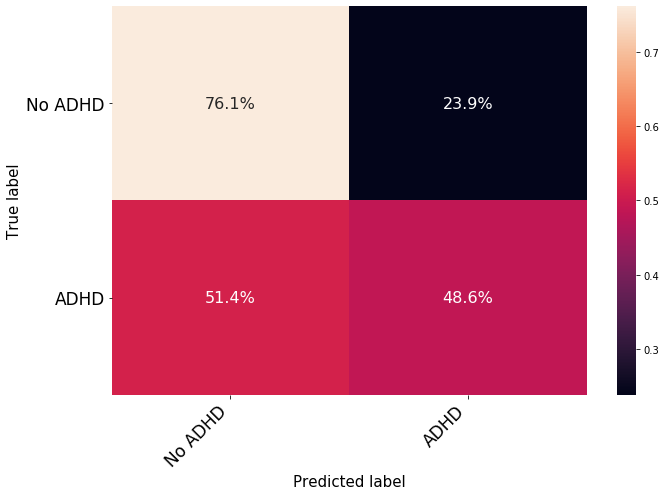

In [30]:
conf_mat = print_confusion_matrix(confusion_matrix(y_test, preds), class_names=["No ADHD", "ADHD"], fontsize=17)

In [31]:
print("recall:", recall_score(y_test, preds))
print("precision:", precision_score(y_test, preds))
print("ROC AUC:", roc_auc_score(y_test, preds))

recall: 0.4864864864864865
precision: 0.5294117647058824
ROC AUC: 0.6238402581686163


In [32]:
probas = voter.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, probas[:,1], pos_label=1)

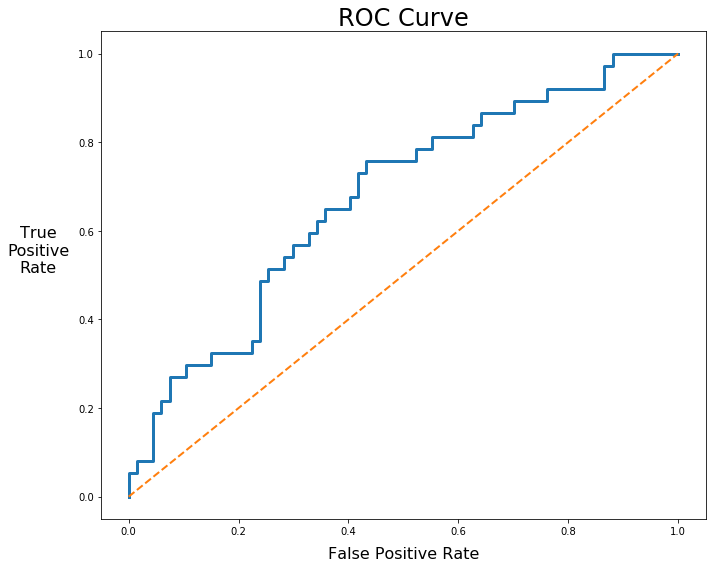

In [33]:
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, linewidth=3)
plt.plot([0,1], [0,1], linestyle="--", linewidth=2)
plt.xlabel("False Positive Rate", fontsize=16, labelpad=10)
plt.ylabel("True\nPositive\nRate", fontsize=16, rotation=0, labelpad=40)
plt.title("ROC Curve", fontsize=24)
plt.tight_layout()
# plt.savefig("ROC_curve.png", dpi=200, transparent=True)

## Average cross validated scores

In [22]:
model_avg_roc_aucs = {}

models = [("Logistic regression", LogisticRegression(C=0.0886)),
              ("KNN", KNeighborsClassifier(n_neighbors=5)),
              ("SVM", svm.SVC(kernel="rbf")),
              ("Naive Bayes", GaussianNB()),
              ("Random forest", RandomForestClassifier(max_depth=4)),
              ("mlp", MLPClassifier(hidden_layer_sizes=(2,), max_iter=1500))]

for model_name, model in models:
    roc_scorer = make_scorer(roc_auc_score)
    scores = cross_val_score(model, X_train, y_train, scoring=roc_scorer, cv = 5)
    model_avg_roc_aucs[model_name] = np.mean(scores)

In [23]:
model_avg_roc_aucs

{'Logistic regression': 0.6113149023830704,
 'KNN': 0.5478354947953243,
 'SVM': 0.5415563306646691,
 'Naive Bayes': 0.6088960937621924,
 'Random forest': 0.5192371677825116,
 'mlp': 0.627952853598015}

## Ensemble Cross val score

In [ ]:
estimators = [("Logistic regression", LogisticRegression(C=0.0886)),
              ("SVM", svm.SVC(probability=True, kernel="rbf")),
              ("Naive Bayes", GaussianNB())]

voter = VotingClassifier(estimators, voting="soft")

voter.fit(X_train, y_train)

roc_scorer = make_scorer(roc_auc_score)
scores = cross_val_score(voter, X_train, y_train, scoring=roc_scorer, cv = 5)
print(scores)
print("mean:", np.mean(scores))

In [ ]:
preds = voter.predict(X_test)
print(roc_auc_score(y_test, preds))
print(confusion_matrix(y_test, preds))